In [1]:
import os, glob
import numpy as np
import pandas as pd
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

DATA_DIR = "data/multi_resolution"
SEQ_LEN = 64

FEATURE_COLS = ["open", "high", "low", "close", "r"]

CLASSES = [
  'BearBat','BearButterfly','BearCrab','BearCypher','BearGartley','BearShark',
  'BullBat','BullButterfly','BullCrab','BullCypher','BullGartley','BullShark'
]
class_to_id = {c:i for i,c in enumerate(CLASSES)}
num_classes = len(CLASSES)

MAX_SEQS_PER_FILE = None
MIN_GROUP_LEN = 1

all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))
print("Found files:", len(all_files))
print(*all_files[:20], sep="\n")

Found files: 17
data/multi_resolution\1day_sigma0.01.csv
data/multi_resolution\1day_sigma0.02.csv
data/multi_resolution\1day_sigma0.05.csv
data/multi_resolution\1day_sigma0.07.csv
data/multi_resolution\1day_sigma0.1.csv
data/multi_resolution\1hour_sigma0.005.csv
data/multi_resolution\1hour_sigma0.01.csv
data/multi_resolution\1hour_sigma0.02.csv
data/multi_resolution\1hour_sigma0.05.csv
data/multi_resolution\1minute_sigma0.001.csv
data/multi_resolution\1minute_sigma0.002.csv
data/multi_resolution\1minute_sigma0.005.csv
data/multi_resolution\1minute_sigma0.01.csv
data/multi_resolution\4hours_sigma0.005.csv
data/multi_resolution\4hours_sigma0.01.csv
data/multi_resolution\4hours_sigma0.02.csv
data/multi_resolution\4hours_sigma0.05.csv


In [3]:
JUNK_COLS = {"Unnamed: 0", "Unnamed:0", "index", "level_0"}

REQUIRED_COLS = {"date", "open", "high", "low", "close", "r", "pattern"}

def load_and_clean_csv(path):
    # Read only needed columns if present 
    # We'll read header first to know what exists
    cols = pd.read_csv(path, nrows=0).columns.tolist()
    cols = [c for c in cols if c not in JUNK_COLS]

    # Ensure we include required cols if they exist
    usecols = [c for c in cols if c in REQUIRED_COLS]

    df = pd.read_csv(path, usecols=usecols)

    # Drop junk cols again just in case
    df = df.drop(columns=[c for c in df.columns if c in JUNK_COLS], errors="ignore")

    # Basic column existence check
    missing = REQUIRED_COLS - set(df.columns)
    if missing:
        raise ValueError(f"{os.path.basename(path)} missing columns: {missing}")

    # Parse date
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.dropna(subset=["date"])
    df = df.sort_values("date")

    # Ensure pattern is string
    df["pattern"] = df["pattern"].fillna("no-pattern").astype(str)

    # Convert features to numeric
    for c in FEATURE_COLS:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Handle NaNs:
    # r NaNs are common -> fill with 0
    df["r"] = df["r"].fillna(0.0)

    # If OHLC are NaN, drop those rows
    df = df.dropna(subset=["open", "high", "low", "close"])

    # Keep only known patterns + no-pattern (filter out typos)
    allowed = set(CLASSES) | {"no-pattern"}
    df = df[df["pattern"].isin(allowed)].copy()

    return df

In [4]:
def df_to_sequences(df):
    # Drop no-pattern for training
    df = df[df["pattern"] != "no-pattern"].copy()
    if len(df) == 0:
        return None, None

    # Group consecutive identical patterns
    df["group_id"] = (df["pattern"] != df["pattern"].shift(1)).cumsum()

    X_list, y_list = [], []

    for _, g in df.groupby("group_id"):
        label = g["pattern"].iloc[0]
        if label not in class_to_id:
            continue

        feat = g[FEATURE_COLS].values.astype(np.float32)

        if len(feat) < MIN_GROUP_LEN:
            continue

        # fixed-length window via pad/truncate
        if len(feat) >= SEQ_LEN:
            seq = feat[-SEQ_LEN:]
        else:
            pad_len = SEQ_LEN - len(feat)
            pad = np.zeros((pad_len, feat.shape[1]), dtype=np.float32)
            seq = np.concatenate([pad, feat], axis=0)

        X_list.append(seq)
        y_list.append(class_to_id[label])

        if MAX_SEQS_PER_FILE is not None and len(X_list) >= MAX_SEQS_PER_FILE:
            break

    if len(X_list) == 0:
        return None, None

    X = np.stack(X_list)  # (n_seq, SEQ_LEN, n_feat)
    y = np.array(y_list, dtype=np.int64)
    return X, y


In [5]:
all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))

EVAL_FILES = [
    os.path.join(DATA_DIR, "1hour_sigma0.01.csv"),
    os.path.join(DATA_DIR, "1minute_sigma0.005.csv"),
    os.path.join(DATA_DIR, "1day_sigma0.02.csv"),
]

# Train files = everything except eval files
train_files = [f for f in all_files if f not in EVAL_FILES]

print("Train files:", len(train_files))
print("Eval files:", len(EVAL_FILES))
print(
    "Overlap(train, eval) =",
    set(map(os.path.basename, train_files)).intersection(
        set(map(os.path.basename, EVAL_FILES))
    )
)


Train files: 14
Eval files: 3
Overlap(train, eval) = set()


In [6]:
total = Counter()
per_file_counts = {}

for path in all_files:
    df = load_and_clean_csv(path)
    X, y = df_to_sequences(df)
    if X is None:
        print("No patterns found in:", os.path.basename(path))
        continue
    counts = Counter(y)
    per_file_counts[os.path.basename(path)] = len(y)
    total.update(counts)

print("Total sequences across files:", sum(per_file_counts.values()))
print("Per-file sequences (first 10):", list(per_file_counts.items())[:10])

# Convert total counts to label names
inv = {v:k for k,v in class_to_id.items()}
print("Total label distribution:")
for k,v in total.most_common():
    print(inv[k], v)

Total sequences across files: 347783
Per-file sequences (first 10): [('1day_sigma0.01.csv', 3225), ('1day_sigma0.02.csv', 1453), ('1day_sigma0.05.csv', 370), ('1day_sigma0.07.csv', 229), ('1day_sigma0.1.csv', 117), ('1hour_sigma0.005.csv', 5523), ('1hour_sigma0.01.csv', 3225), ('1hour_sigma0.02.csv', 1453), ('1hour_sigma0.05.csv', 370), ('1minute_sigma0.001.csv', 178282)]
Total label distribution:
BearButterfly 47616
BullButterfly 46145
BearGartley 43593
BullGartley 42532
BearShark 34237
BullShark 33792
BullCypher 18607
BearCypher 17541
BullBat 17082
BullCrab 16480
BearBat 15157
BearCrab 15001


In [7]:
#We use one global scaler for everything
scaler = StandardScaler()

for path in train_files:
    df = load_and_clean_csv(path)
    X, y = df_to_sequences(df)
    if X is None:
        continue

    Xp = X.reshape(-1, X.shape[-1])
    nonpad = ~(np.all(Xp == 0, axis=1))   # ignore padded rows
    scaler.partial_fit(Xp[nonpad])

def scale_X(X):
    s, t, f = X.shape
    X2 = X.reshape(-1, f)
    X2 = scaler.transform(X2)
    return X2.reshape(s, t, f).astype(np.float32)

In [8]:
def dilated_conv_block(x, filters, kernel_size, dilation, dropout=0.0, name=None):
    x = layers.Conv1D(
        filters=filters,
        kernel_size=kernel_size,
        dilation_rate=dilation,
        padding="same",
        use_bias=False,
        name=None if name is None else f"{name}_conv_k{kernel_size}_d{dilation}"
    )(x)
    x = layers.BatchNormalization(name=None if name is None else f"{name}_bn_k{kernel_size}_d{dilation}")(x)
    x = layers.ReLU(name=None if name is None else f"{name}_relu_k{kernel_size}_d{dilation}")(x)
    if dropout and dropout > 0:
        x = layers.Dropout(dropout, name=None if name is None else f"{name}_drop_k{kernel_size}_d{dilation}")(x)
    return x

def module_7(x, filters=64, dropout=0.0, name="m7"):
    x = dilated_conv_block(x, filters, 3, 1, dropout, name)
    x = dilated_conv_block(x, filters, 3, 2, dropout, name)
    return x

def module_10(x, filters=64, dropout=0.0, name="m10"):
    x = dilated_conv_block(x, filters, 3, 1, dropout, name)
    x = dilated_conv_block(x, filters, 3, 2, dropout, name)
    x = dilated_conv_block(x, filters, 2, 4, dropout, name)
    return x

def module_15(x, filters=64, dropout=0.0, name="m15"):
    x = dilated_conv_block(x, filters, 3, 1, dropout, name)
    x = dilated_conv_block(x, filters, 3, 2, dropout, name)
    x = dilated_conv_block(x, filters, 3, 4, dropout, name)
    return x

def build_liu_si_cnn_lstm(seq_len, num_features, num_classes,
                          filters=64, module_dropout=0.1, head_dropout=0.3,
                          lstm_units=64, bidirectional=True):
    inp = layers.Input(shape=(seq_len, num_features), name="input")

    x_in = inp

    b7  = module_7(x_in,  filters=filters, dropout=module_dropout, name="module7")
    b10 = module_10(x_in, filters=filters, dropout=module_dropout, name="module10")
    b15 = module_15(x_in, filters=filters, dropout=module_dropout, name="module15")

    x = layers.Concatenate(name="concat")([b7, b10, b15])

    x = layers.MaxPooling1D(pool_size=2, name="maxpool")(x)

    # 1x1 conv to mix channels after concatenation
    x = layers.Conv1D(filters=filters, kernel_size=1, padding="same", use_bias=False, name="conv1x1")(x)
    x = layers.BatchNormalization(name="conv1x1_bn")(x)
    x = layers.ReLU(name="conv1x1_relu")(x)

    x = layers.Dropout(head_dropout, name="head_dropout")(x)

    # LSTM goes here (while time dimension still exists)
    if bidirectional:
        x = layers.Bidirectional(layers.LSTM(lstm_units), name="bilstm")(x)
    else:
        x = layers.LSTM(lstm_units, name="lstm")(x)

    # Classifier head
    x = layers.Dropout(0.3, name="post_lstm_dropout")(x)
    x = layers.Dense(64, activation="relu", name="fc")(x)
    x = layers.Dropout(0.3, name="fc_dropout")(x)

    out = layers.Dense(num_classes, activation="softmax", name="softmax")(x)

    return Model(inp, out, name="LiuSi_CNN_BiLSTM")


In [9]:
seq_len = SEQ_LEN
num_features = len(FEATURE_COLS)
num_classes = len(CLASSES)

cnn_lstm = build_liu_si_cnn_lstm(
    seq_len=SEQ_LEN,
    num_features=len(FEATURE_COLS),
    num_classes=len(CLASSES),
    filters=64,
    module_dropout=0.1,
    head_dropout=0.3,
    lstm_units=64,
    bidirectional=True
)

cnn_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

cnn_lstm.summary()


Model: "LiuSi_CNN_BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)            │ (None, 64, 5)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module10_conv_k3_d1 (Conv1D)  │ (None, 64, 64)            │             960 │ input[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module15_conv_k3_d1 (Conv1D)  │ (None, 64, 64)            │             960 │ input[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module10_bn_k3_d1             │ (None, 64, 64)            │             256 │ module10_conv_k3_d1[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module15_bn_k3_d1             │ (None, 64, 64)            │             256 │ module15_conv_k3_d1[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module10_relu_k3_d1 (ReLU)    │ (None, 64, 64)            │               0 │ module10_bn_k3_d1[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module15_relu_k3_d1 (ReLU)    │ (None, 64, 64)            │               0 │ module15_bn_k3_d1[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module10_drop_k3_d1 (Dropout) │ (None, 64, 64)            │               0 │ module10_relu_k3_d1[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module15_drop_k3_d1 (Dropout) │ (None, 64, 64)            │               0 │ module15_relu_k3_d1[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module7_conv_k3_d1 (Conv1D)   │ (None, 64, 64)            │             960 │ input[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module10_conv_k3_d2 (Conv1D)  │ (None, 64, 64)            │          12,288 │ module10_drop_k3_d1[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module15_conv_k3_d2 (Conv1D)  │ (None, 64, 64)            │          12,288 │ module15_drop_k3_d1[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module7_bn_k3_d1              │ (None, 64, 64)            │             256 │ module7_conv_k3_d1[0][0]   │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module10_bn_k3_d2             │ (None, 64, 64)            │             256 │ module10_conv_k3_d2[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module15_bn_k3_d2             │ (None, 64, 64)            │             256 │ module15_conv_k3_d2[0][0]  │
│ (BatchNormalization)          │                           │               

 Total params: 149,900 (585.55 KB)

 Trainable params: 148,748 (581.05 KB)

 Non-trainable params: 1,152 (4.50 KB)

In [10]:
# Define evaluation files FIRST (so we can exclude them from training)
EVAL_FILES = [
    "1hour_sigma0.01.csv",
    "1minute_sigma0.005.csv",
    "1day_sigma0.02.csv"
]
EVAL_FILES = [os.path.join(DATA_DIR, f) for f in EVAL_FILES]
eval_set = set(EVAL_FILES)

# Build a small fixed validation set (from NON-eval files) This is used for early stopping across global passes.
X_val_list, y_val_list = [], []
VAL_TARGET_SEQS = 4000  # you can lower this if memory/time is an issue

for path in train_files:
    if path in eval_set:
        continue
    df = load_and_clean_csv(path)
    X, y = df_to_sequences(df)
    if X is None:
        continue
    X = scale_X(X)
    X_val_list.append(X)
    y_val_list.append(y)
    if sum(len(a) for a in y_val_list) >= VAL_TARGET_SEQS:
        break

X_val = np.concatenate(X_val_list, axis=0)
y_val = np.concatenate(y_val_list, axis=0)

# Optional shuffle and cap exactly
idx = np.random.permutation(len(X_val))
X_val, y_val = X_val[idx], y_val[idx]
if len(X_val) > VAL_TARGET_SEQS:
    X_val, y_val = X_val[:VAL_TARGET_SEQS], y_val[:VAL_TARGET_SEQS]

print("Validation set shape:", X_val.shape, y_val.shape)

Validation set shape: (4000, 64, 5) (4000,)


In [11]:
# Compute class weights from training distribution (excluding eval files)
y_for_weights = []

for path in train_files:
    df = load_and_clean_csv(path)
    X, y = df_to_sequences(df)
    if X is None:
        continue
    y_for_weights.append(y)

y_for_weights = np.concatenate(y_for_weights, axis=0)

weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=y_for_weights
)
class_weight_dict = {i: float(w) for i, w in enumerate(weights)}
print("Class weights:", class_weight_dict)


Class weights: {0: 1.8815603614135068, 1: 0.6114032588653324, 2: 1.90142621579051, 3: 1.6657772746873651, 4: 0.666932114431726, 5: 0.8498190557902147, 6: 1.669665240318119, 7: 0.6314930155382817, 8: 1.734787245986303, 9: 1.5673371472622888, 10: 0.6839720776231453, 11: 0.8535369437447523}


In [12]:
PATIENCE = 3
best_val_loss = np.inf
patience_counter = 0
best_weights = None

EPOCHS_PER_FILE = 1
BATCH_SIZE = 64
GLOBAL_PASSES = 20

for gp in range(GLOBAL_PASSES):
    train_files_shuffled = train_files.copy()
    np.random.shuffle(train_files_shuffled)
    print(f"\n=== Global pass {gp+1}/{GLOBAL_PASSES} ===")

    for path in train_files_shuffled:
        df = load_and_clean_csv(path)
        X, y = df_to_sequences(df)
        if X is None:
            continue

        X = scale_X(X)

        idx = np.random.permutation(len(X))
        X, y = X[idx], y[idx]

        cnn_lstm.fit(
            X, y,
            epochs=EPOCHS_PER_FILE,
            batch_size=BATCH_SIZE,
            verbose=0,
            class_weight=class_weight_dict
        )

    val_loss, val_acc = cnn_lstm.evaluate(X_val, y_val, verbose=0)
    print(f"Validation -> loss: {val_loss:.4f} | acc: {val_acc:.4f}")

    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        patience_counter = 0
        best_weights = cnn_lstm.get_weights()
        print("Improved val_loss. Saved best weights.")
    else:
        patience_counter += 1
        print(f"No improvement. patience {patience_counter}/{PATIENCE}")
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

# Restore best weights at end
if best_weights is not None:
    cnn_lstm.set_weights(best_weights)
    print("Restored best model weights from validation.")



=== Global pass 1/20 ===
Validation -> loss: 1.7485 | acc: 0.3820
Improved val_loss. Saved best weights.

=== Global pass 2/20 ===
Validation -> loss: 1.8383 | acc: 0.3435
No improvement. patience 1/3

=== Global pass 3/20 ===
Validation -> loss: 1.7131 | acc: 0.4123
Improved val_loss. Saved best weights.

=== Global pass 4/20 ===
Validation -> loss: 1.7041 | acc: 0.4095
Improved val_loss. Saved best weights.

=== Global pass 5/20 ===
Validation -> loss: 1.6416 | acc: 0.4182
Improved val_loss. Saved best weights.

=== Global pass 6/20 ===
Validation -> loss: 1.9313 | acc: 0.3375
No improvement. patience 1/3

=== Global pass 7/20 ===
Validation -> loss: 1.6062 | acc: 0.4433
Improved val_loss. Saved best weights.

=== Global pass 8/20 ===
Validation -> loss: 1.8646 | acc: 0.3580
No improvement. patience 1/3

=== Global pass 9/20 ===
Validation -> loss: 1.6652 | acc: 0.4280
No improvement. patience 2/3

=== Global pass 10/20 ===
Validation -> loss: 1.6791 | acc: 0.4210
No improvement. pa

In [13]:
# Build the Evaluation dataset
X_eval_list = []
y_eval_list = []

for path in EVAL_FILES:
    df = load_and_clean_csv(path)
    X, y = df_to_sequences(df)
    if X is None:
        continue
    X = scale_X(X)
    X_eval_list.append(X)
    y_eval_list.append(y)

X_eval = np.concatenate(X_eval_list, axis=0)
y_eval = np.concatenate(y_eval_list, axis=0)

print("Evaluation set shape:", X_eval.shape, y_eval.shape)


Evaluation set shape: (38748, 64, 5) (38748,)


In [14]:
# Run cnn_lstm predictions + report
y_probs = cnn_lstm.predict(X_eval, verbose=0)
y_pred = np.argmax(y_probs, axis=1)

print(
    classification_report(
        y_eval,
        y_pred,
        labels=np.arange(num_classes),
        target_names=CLASSES,
        zero_division=0
    )
)

               precision    recall  f1-score   support

      BearBat       0.46      0.12      0.19      1470
BearButterfly       0.50      0.38      0.43      5495
     BearCrab       0.36      0.25      0.29      1457
   BearCypher       0.15      0.64      0.25      2081
  BearGartley       0.53      0.35      0.42      4979
    BearShark       0.37      0.26      0.31      3933
      BullBat       0.45      0.20      0.28      1658
BullButterfly       0.48      0.37      0.42      5364
     BullCrab       0.37      0.19      0.25      1635
   BullCypher       0.16      0.58      0.25      2176
  BullGartley       0.47      0.38      0.42      4880
    BullShark       0.44      0.12      0.18      3620

     accuracy                           0.33     38748
    macro avg       0.40      0.32      0.31     38748
 weighted avg       0.43      0.33      0.34     38748



In [15]:
print("Eval files:", [os.path.basename(p) for p in EVAL_FILES])

# Ensure eval files are NOT in training list:
train_set = set(map(os.path.basename, train_files))
eval_set  = set(map(os.path.basename, EVAL_FILES))
print("Overlap(train, eval) =", train_set.intersection(eval_set))


Eval files: ['1hour_sigma0.01.csv', '1minute_sigma0.005.csv', '1day_sigma0.02.csv']
Overlap(train, eval) = set()


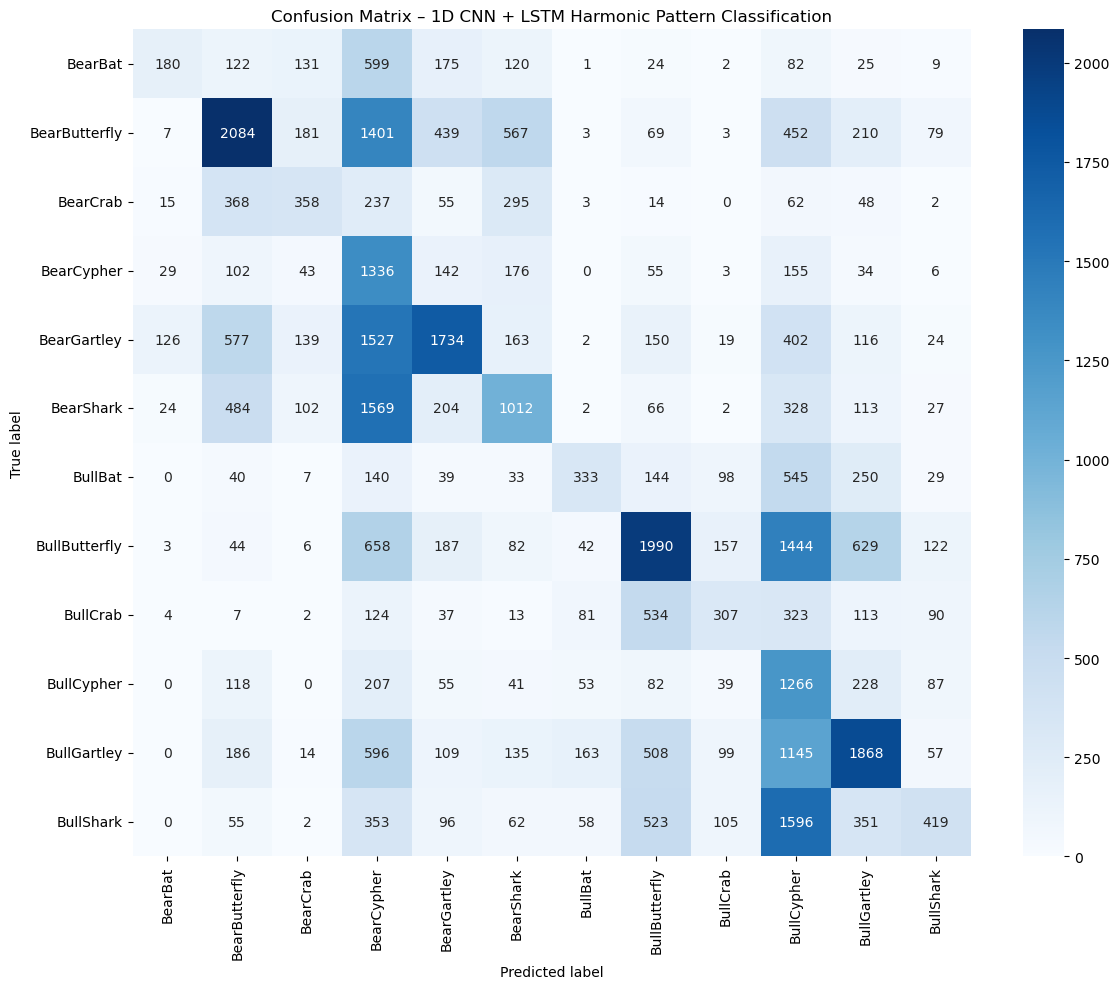

In [16]:
cm = confusion_matrix(
    y_eval,
    y_pred,
    labels=np.arange(num_classes)
)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASSES,
    yticklabels=CLASSES
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – 1D CNN + LSTM Harmonic Pattern Classification")
plt.tight_layout()
plt.show()